In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import astropy.constants as c
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [3]:
srate = 4096*4
t_range=np.arange(-1,1,1/srate)
input = dict(model_list = [(2,2,0, 'p')],
             t_init = 0,
             segment_length = 0.2,
             srate = 4096*4,
             ra = None, dec = None,)

In [44]:
SNR_arr = []
err_arr = []

for i in range(100):
    injected = [np.random.uniform(45, 150, 1)[0], np.random.uniform(0, 0.85, 1)[0]]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal=1e-22*np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    padded = qnm_filter.pad_data_for_fft(qnm_filter.RealData(signal, index=t_range), 2,2)
    waveform = qnm_filter.RealData(padded[1], index=padded[0])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = 5e-23**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    template = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
    fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,2,1,'p')])
    template_res = fit.truncate_data(fit.filtered_data)['H1']
    SNR_res = fit.compute_SNR(None, template_res, 'H1', optimal=True)
    FF = np.sqrt(1-SNR_res**2/SNR**2)

    filt221_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])
    filt220_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])

    error = (filt220_likelihood - filt221_likelihood)-((1-FF**2)*SNR**2/2)
    SNR_arr.append(SNR)
    err_arr.append(error)

Text(0, 0.5, 'Cumulative frequency')

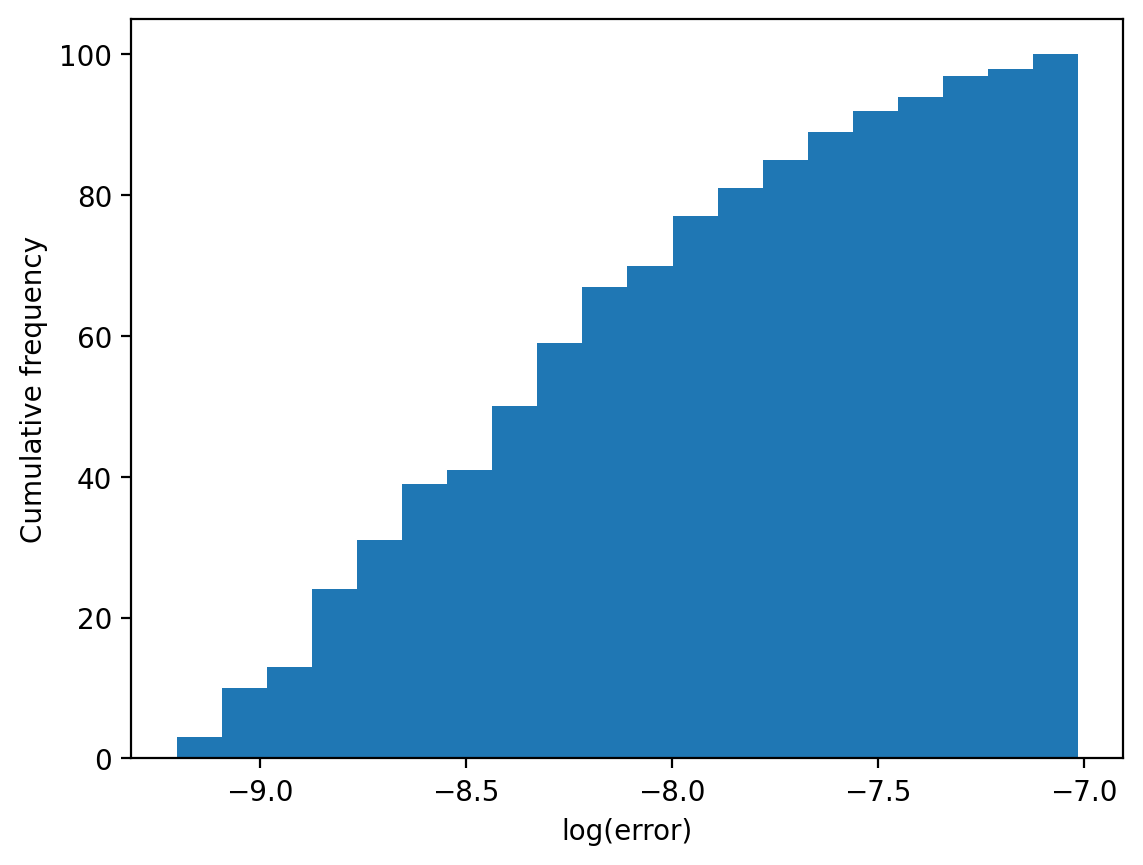

In [46]:
pl.hist(np.log10(np.abs(err_arr)), bins=20, cumulative=True);
pl.xlabel("log(error)")
pl.ylabel("Cumulative frequency")

Text(0, 0.5, 'Error of relation')

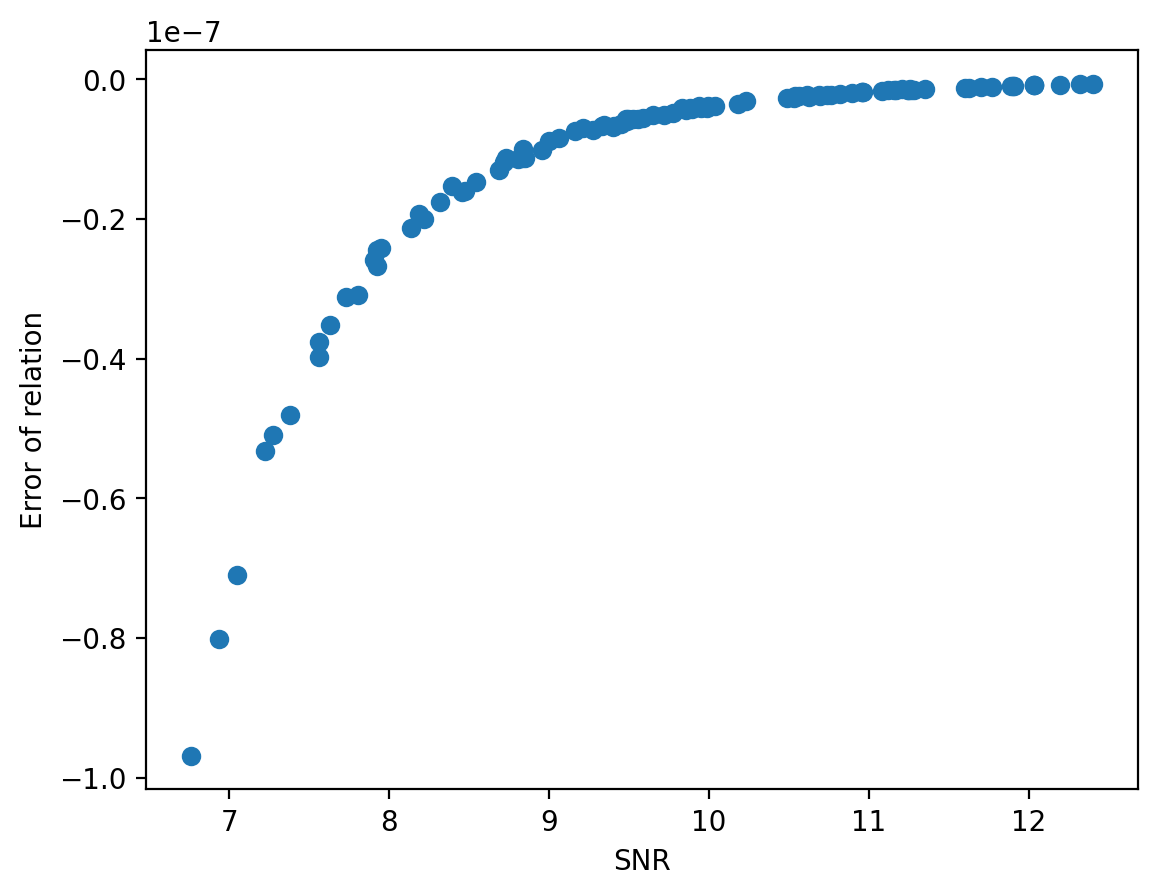

In [51]:
pl.plot(SNR_arr, err_arr, 'o')
# pl.plot(SNR_arr, np.log10(np.abs(err_arr)), 'o')
pl.xlabel("SNR")
pl.ylabel("Error of relation")

In [52]:
np.polyfit(SNR_arr, np.log10(np.abs(err_arr)), deg=1)

array([-0.37383498, -4.63790866])

## Pointwise

In [8]:
# Here the null hypothesis is no signal. So the FF is 0

template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
filt_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])
nofilt_likelihood = fit.compute_likelihood(apply_filter=False)

np.isclose(filt_likelihood-nofilt_likelihood, SNR**2/2)

True

In [11]:
# H0 = 220, H1 = 221. Calculate the FF from the residual SNR

template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,2,1,'p')])
template_res = fit.truncate_data(fit.filtered_data)['H1']
SNR_res = fit.compute_SNR(None, template_res, 'H1', optimal=True)
FF = np.sqrt(1-SNR_res**2/SNR**2)

filt221_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])
filt220_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])

(filt220_likelihood - filt221_likelihood)-((1-FF**2)*SNR**2/2)

-1.7709717496927624e-06

In [87]:
# H0 = 220, H1 = 210. Calculate the FF from the residual SNR

template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,1,0,'p')])
template_210 = fit.truncate_data(fit.filtered_data)['H1']
SNR_210 = fit.compute_SNR(None, template_210, 'H1', optimal=True)
FF = np.sqrt(1-SNR_210**2/SNR**2)

filt210_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,1,0,'p')])
filt220_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])

np.isclose(filt220_likelihood - filt210_likelihood, (1-FF**2)*SNR**2/2)

True

In [88]:
# H0 = 210, H1 = 221. Calculate the FF from the residual SNR

fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,1,0,'p')])
template_210 = fit.truncate_data(fit.filtered_data)['H1']
SNR_210 = fit.compute_SNR(None, template_210, 'H1', optimal=True)
fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,2,1,'p')])
template_221 = fit.truncate_data(fit.filtered_data)['H1']
SNR_221 = fit.compute_SNR(None, template_221, 'H1', optimal=True)
FF = np.sqrt(1-SNR_210**2/SNR_221**2)

filt221_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])
filt210_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,1,0,'p')])

np.isclose(filt221_likelihood - filt210_likelihood, 0.5*(SNR_210**2 - SNR_221**2))

True